In [44]:
import json
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%config Completer.use_jedi = False

In [10]:
DATASET_PATH = ".\\data\\data_10.json"

In [14]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    # convert lists into NumPy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

In [15]:
def prepare_datasets(test_size, valid_size):
    
    # load in the data
    X, y = load_data(DATASET_PATH)
    
    # create the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=10)
    
    # create the train-validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                          test_size=valid_size, 
                                                          random_state=10)
    
    # TensorFlow expects a 3D array (tensor as input):  (130, 13, 1)  
    # So we need to add channel (depth) = 1
    X_train = X_train[..., np.newaxis]  # now X_train is 4D -> (num_samples, 130, 13, 1)
    X_valid = X_valid[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [32]:
def build_model(input_shape):
    
    # create model: CNN with 3 convolutional layers, following by max-pooling layers
    model = keras.Sequential()
    
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [28]:
def plot_training_history(history):
    
    # create new figure object with 2 subplots
    fig, ax = plt.subplots(2, figsize=(8,6), dpi=150)
    
    # 1. create accuracy subplot
    ax[0].plot(history.history["accuracy"], label="train accuracy")
    ax[0].plot(history.history["val_accuracy"], label="test accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc="lower right")
    ax[0].set_title("Accuracy Evaluation")
    
    # 2. create error subplot
    ax[1].plot(history.history["loss"], label="train error")
    ax[1].plot(history.history["val_loss"], label="test error")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Error")
    ax[1].legend(loc="upper right")
    ax[1].set_title("Error Evaluation")    
    
    # display the two plots
    plt.tight_layout()
    plt.show()

In [24]:
def predict(model, X, y):
    
    # augment X array with extra axis at the beginning
    X = X[np.newaxis, ...]
    
    # determine the predicted values: y_pred = [ [0.2, 0.3, ...] ]
    y_pred = model.predict(X)  # X is (130, 13, 1) but should be (n, 130, 13, 1)
    
    # extract index with max value
    predicted_index = np.argmax(y_pred, axis=1)  # --> 1D array, index between 0 and 9; e.g. [4]
    
    # print the output
    print("Expected index: {}, Predicted index: {}".format(y, predicted_index) )

* Create train, validation, and test sets
* Build the CNN
* Compile the CNN
* Train the CNN
* Evaluate the CNN on the test set
* Make predictions on a sample

In [29]:
# create train, validation, and test sets 
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_datasets(test_size=0.10, 
                                                                      valid_size=0.10)  # (test_size, valid_size)

In [30]:
X_train.shape

(8080, 130, 13, 1)

In [33]:
# build the CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

In [34]:
# compile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics="accuracy")
model.summary()

In [46]:
# train the CNN
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, 
                    epochs=64)

Epoch 1/64
253/253 [==============================] - 12s 48ms/step - loss: 1.2582 - accuracy: 0.5504 - val_loss: 1.0968 - val_accuracy: 0.6448
Epoch 2/64
253/253 [==============================] - 11s 45ms/step - loss: 1.2020 - accuracy: 0.5765 - val_loss: 1.0618 - val_accuracy: 0.6325
Epoch 3/64
253/253 [==============================] - 11s 44ms/step - loss: 1.1279 - accuracy: 0.6012 - val_loss: 1.0445 - val_accuracy: 0.6548
Epoch 4/64
253/253 [==============================] - 11s 44ms/step - loss: 1.0763 - accuracy: 0.6239 - val_loss: 0.9655 - val_accuracy: 0.6726
Epoch 5/64
253/253 [==============================] - 13s 51ms/step - loss: 1.0454 - accuracy: 0.6338 - val_loss: 0.9373 - val_accuracy: 0.6826
Epoch 6/64
253/253 [==============================] - 13s 52ms/step - loss: 1.0019 - accuracy: 0.6516 - val_loss: 0.9168 - val_accuracy: 0.6893
Epoch 7/64
253/253 [==============================] - 13s 52ms/step - loss: 0.9579 - accuracy: 0.6724 - val_loss: 0.9008 - val_accuracy:

253/253 [==============================] - 20s 80ms/step - loss: 0.3672 - accuracy: 0.8744 - val_loss: 0.7317 - val_accuracy: 0.7684
Epoch 58/64
253/253 [==============================] - 19s 75ms/step - loss: 0.3706 - accuracy: 0.8718 - val_loss: 0.7133 - val_accuracy: 0.7673
Epoch 59/64
253/253 [==============================] - 15s 59ms/step - loss: 0.3574 - accuracy: 0.8772 - val_loss: 0.6869 - val_accuracy: 0.7673
Epoch 60/64
253/253 [==============================] - 17s 66ms/step - loss: 0.3532 - accuracy: 0.8774 - val_loss: 0.7197 - val_accuracy: 0.7706
Epoch 61/64
253/253 [==============================] - 15s 58ms/step - loss: 0.3385 - accuracy: 0.8803 - val_loss: 0.7162 - val_accuracy: 0.7739
Epoch 62/64
253/253 [==============================] - 15s 57ms/step - loss: 0.3406 - accuracy: 0.8813 - val_loss: 0.7581 - val_accuracy: 0.7661
Epoch 63/64
253/253 [==============================] - 14s 57ms/step - loss: 0.3332 - accuracy: 0.8845 - val_loss: 0.7179 - val_accuracy: 0.75

In [47]:
# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

32/32 [==============================] - 0s 14ms/step - loss: 0.6787 - accuracy: 0.7786
Accuracy on test set is: 0.7785571217536926


In [48]:
# make a prediction on a small sample
test_no = 47
Xi = X_test[test_no]
yi = y_test[test_no]
predict(model, Xi, yi)

Expected index: 3, Predicted index: [3]


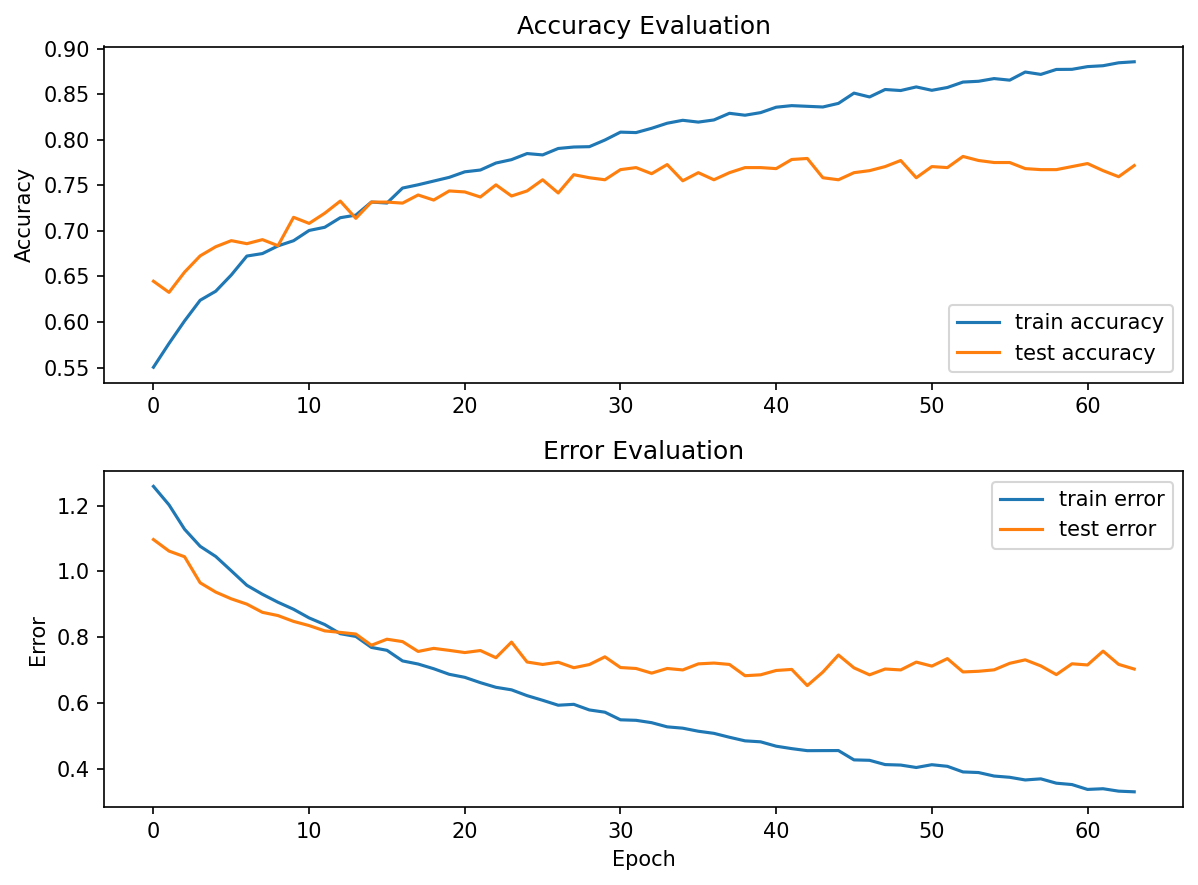

In [49]:
# plot the history of training and test errors / accuracy
plot_training_history(history)